In [1]:
%load_ext autoreload
%autoreload 2

# Small Slab (zero ions)

## Run simulation

Reading mesh_ex06.1.node
Reading mesh_ex06.1.ele
Reading mesh_ex06.1.edge

Computing shape functions of triangular elements
This will take a minute
Time elapsed  2.9329092502593994 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  1.6373348236083984 sec

Finding adjacent elements for line segments
This will take a minute
Time elapsed  136.63796138763428 sec

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  50.994078397750854 sec

Assembling the system of equations for line segments
Time elapsed  4.685938596725464 sec

Incoorprating the boundary condition of the third kind
Time elapsed  4.001634359359741 sec

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  4.476599454879761 sec

Computing frequency dependent solutions for:
ratio: 1.00
freq [Hz] : 4.77E+03 - 4.77E+03 : 1 [min-max; #]
This will take a while


100%|████████████████████████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Time elapsed  7.27850079536438 sec

Computing fields and gradients in elements
Time elapsed  0.013036012649536133 sec



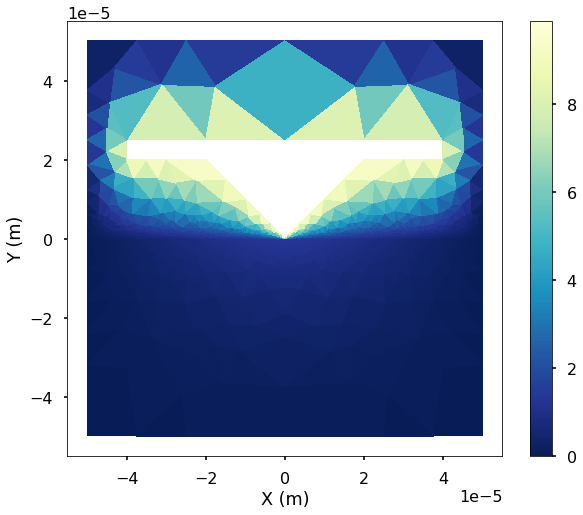

Computing fields and gradients in elements
Time elapsed  0.016810178756713867 sec



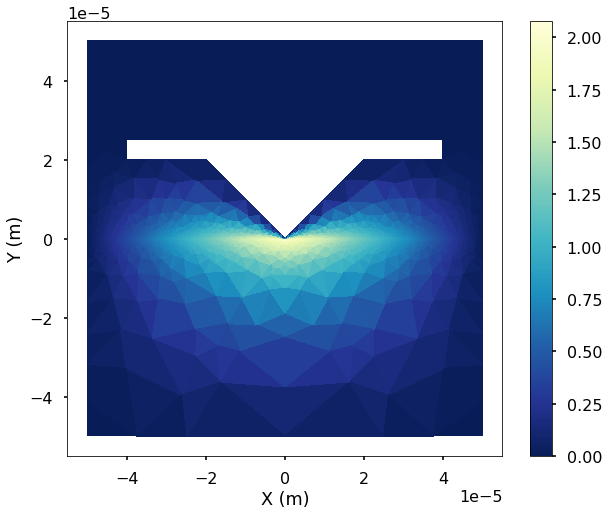

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

import numpy as np
from lib.mesh import Mesh
from lib.materials import PerturbPNP,Physics
from lib.assembly import PerturbFEM

#import mesh
mesh = Mesh.importer(
    prefix = 'mesh_ex06',
    axis_symmetry = 'Y',
    unscale_factor=1e-6,
    )

#define physical parameters
physics = Physics(
    c_ion = [0.0,0.0], #ion concentration at infinity [mol/m^3]
    z_ion = [-1.0,1.0], #ion valence or charge number [SI]
    mu_a = [5e-8,5e-8], #ion mobility in electrolyte [m^2/(Vs)]
    mu_s = 5e-9, #ion mobility in solid [m^2/(Vs)]
    rel_perm_a = 80.0, #relative permittivity of electrolyte [SI]
    rel_perm_i = 4.5, #relative permittivity of solid [SI]
    sigma_solid = -0.01, #surface charge density for solid [C] #sigma_intrinsic
    temperature = 293.0, #ambient temperature [K]
    e_0 = [0.0,0.0], #Ex/Ey at infinity
    f_0 = [[0.0,0.0,0.0]], #x/y/charge density at point sources
    s_0 = 10.0, #voltage on equipotential surface
    radius_a = 0.0, #radius of sphere particle
    is_solid_metal = False, #True if solid is metal otherwise false
    )

#build PDE using pre-defined physics
pnp = PerturbPNP(physics)

#build FEM system
slab = PerturbFEM(mesh,pnp)
slab.ftsolve(ratio=[1.0],freqtime=[3e4/(2*np.pi)],n_proc=1)

#display results
mesh.tripcolor(np.real(slab.fsol[0][0,:,-2]),cmap='YlGnBu_r')
mesh.tripcolor(np.imag(slab.fsol[0][0,:,-2]),cmap='YlGnBu_r')


## Digital linear filter

In [3]:
slab.ftsolve(ratio=[1.0],freqtime=np.logspace(-6,1,301),signal=1,ft='dlf',
             ftarg={},n_proc=1)

   time        [s] :  1E-06 - 10 : 301  [min-max; #]
   Fourier         :  DLF (Sine-Filter)
     > Filter      :  Key 81 CosSin (2009)
     > DLF type    :  Lagged Convolution

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  3.121537208557129 sec

Computing frequency dependent solutions for:
ratio: 1.00
freq [Hz] : 5.34E-06 - 5.15E+08 : 162 [min-max; #]
This will take a while


100%|████████████████████████████████████████| 162/162 [09:40<00:00,  3.58s/it]


Time elapsed  580.3018789291382 sec



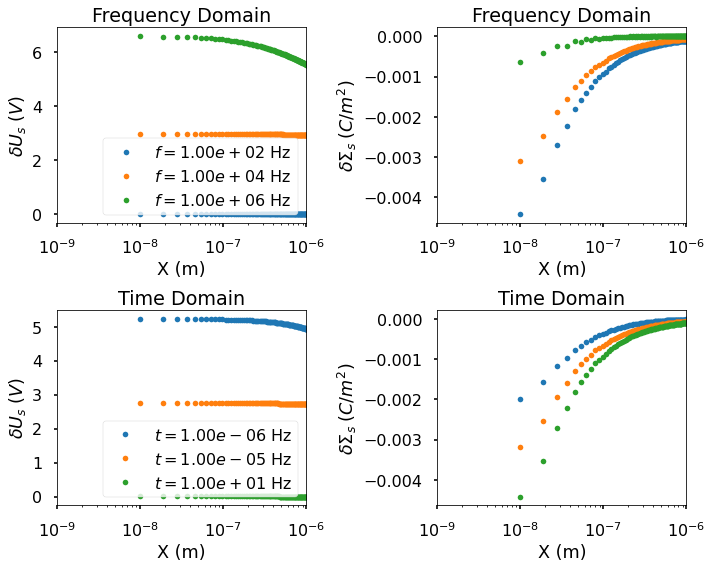

In [76]:
slab.animate(freq=[1e2,1e4,1e6],time=[1e-6,1e-5,1e1],xlim=[1e-9,1e-6],xscale='log',yscale='linear')
# slab.animate(time=slab.time[:100:10],xlim=[1e-9,1e-6],ylim=[1e-5,1e-2],xscale='linear',yscale='log')

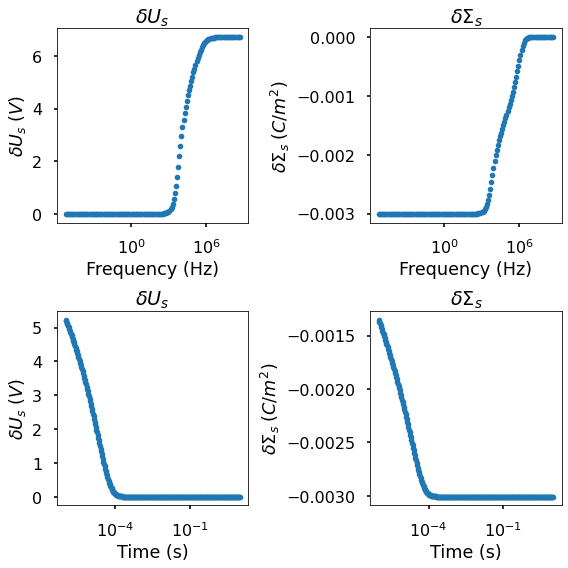

In [64]:
slab.plot(x=0,y=0)

# More tests

## Frequency domain results

(X,Y) [ 0. -0.]


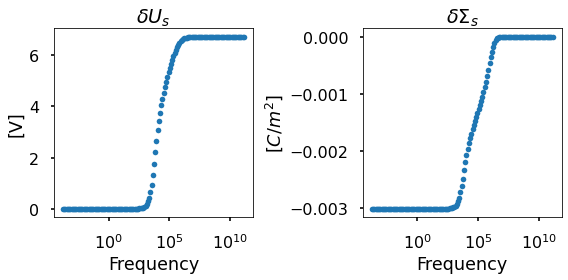

In [50]:
def test():
    fEM = np.transpose(np.array(slab.sol[0]),axes=(2,1,0)) #(n_rep,n_node,n_f)
    fEM = fEM[:,mesh.is_on_stern,:]
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    axes = ax.flatten()
    nodes = mesh.nodes[mesh.is_on_stern]
    mask = nodes[:,0]==0
    print('(X,Y)',np.squeeze(nodes[mask,:]))
    
    axes[0].plot(freq,np.squeeze(np.real(fEM[-2,mask,:])),'.')
    axes[0].set_xscale('log')
    axes[0].set_title('$\delta U_s$')
    axes[0].set_ylabel('[V]')
    axes[0].set_xlabel('Frequency')

    axes[1].plot(freq,np.squeeze(np.real(fEM[-1,mask,:])),'.')
    axes[1].set_xscale('log')
    axes[1].set_title('$\delta \Sigma_s$')
    axes[1].set_ylabel('$[C/m^2]$')
    axes[1].set_xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    return
test()

## Time domain results

(X,Y) [3.99801758e-06 0.00000000e+00]


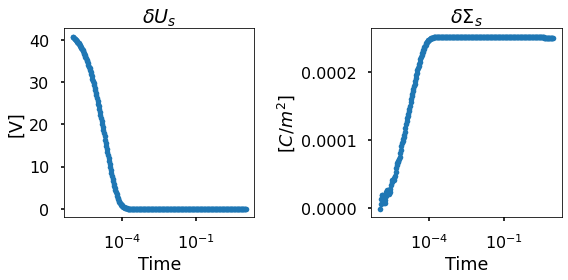

In [103]:
def test():
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    axes = ax.flatten()
    nodes = mesh.nodes[mesh.is_on_stern]
    n_ind = np.argmin((nodes[:,0]-4e-6)**2)
    print('(X,Y)',nodes[n_ind,:])
    
    axes[0].plot(time,np.squeeze(tEM[0][-2,n_ind,:]),'.')
    axes[0].set_xscale('log')
    axes[0].set_title('$\delta U_s$')
    axes[0].set_ylabel('[V]')
    axes[0].set_xlabel('Time')
#     axes[0].set_yscale('log')
#     axes[0].set_ylim([6e-2,1e-1])
    
    axes[1].plot(time,-np.squeeze(tEM[0][-1,n_ind,:]),'.')
    axes[1].set_xscale('log')
    axes[1].set_title('$\delta\Sigma_s$')
    axes[1].set_ylabel('$[C/m^2]$')
    axes[1].set_xlabel('Time')
#     axes[1].set_yscale('log')
#     axes[1].set_ylim([2.8e-2,3.2e-2])

    plt.tight_layout()
    plt.show()
    return

test()

time: 1e-06
time 1e-06
time 1.711328304161781e-06
time 2.9286445646252375e-06
time 5.011872336272725e-06
time 8.576958985908945e-06
time 1.4677992676220705e-05
time 2.5118864315095822e-05
time 4.2986623470822724e-05
time 7.356422544596421e-05
time 0.00012589254117941674


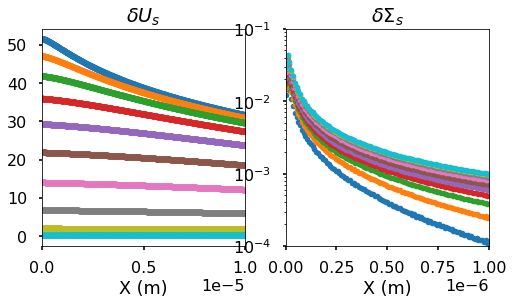

In [140]:
def test():
    nodes = mesh.nodes
    mask = (mesh.is_on_stern)
    t_ind = np.argmin((time-0)**2)
    print('time:',time[t_ind])
    
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    axes = ax.flatten()

    for i in range(0,100,10):
        print('time',time[i])
        axes[0].plot(nodes[mask,0],np.squeeze(tEM[0][-2,:,i]),'.')
        axes[0].set_title('$\delta U_s$')
        axes[0].set_xlabel('X (m)')
        #axes[0].plot(-nodes[mask,0],np.squeeze(tEM[0][-2,:,t_ind]),'.')
        axes[0].set_xlim([0,1e-5])

        axes[1].plot(nodes[mask,0],-np.squeeze(tEM[0][-1,:,i]),'.')
        axes[1].set_title('$\delta \Sigma_s$')
        axes[1].set_xlabel('X (m)')
        axes[1].set_xlim([0,1e-6])
    #     axes[1].set_xscale('log')
        axes[1].set_yscale('log')
        axes[1].set_ylim([1e-4,1e-1])

    return

test()